# 0. Imports

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax
# %pip install jax-dataloader
# %pip install avalanche-lib

In [1]:
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
from dataclasses import dataclass

from itertools import cycle

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from bayes_opt import BayesianOptimization
from tqdm import trange

import jax_dataloader.core as jdl

from rebayes.base import *
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
from rebayes.utils.utils import *
from rebayes.utils.avalanche import *
from rebayes.sgd_filter import sgd
from demos.showdown.nonstationary import hparam_tune_clf as hpt
from avalanche.benchmarks.classic import SplitMNIST

2023-03-05 17:09:30.388240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-05 17:09:31.224943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-05 17:09:31.225083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-05 17:09:31.225094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use

# 1. Load Dataset

In [2]:
def load_split_mnist_dataset(n_tasks=5, ntrain_per_task=200, ntest_per_task=500, key=0):
    dataset = SplitMNIST(n_experiences=n_tasks, seed=0, return_task_id=True,
                         class_ids_from_zero_in_each_exp=True, fixed_class_order=range(10))
    nval_per_batch = ntest_per_task
    Xtr, Ytr, Xte, Yte =  make_avalanche_data(dataset, ntrain_per_task, ntrain_per_task, 2*ntest_per_task, key=key)
    Xtr, Xte = Xtr.reshape(-1, 1, 28, 28, 1), Xte.reshape(-1, 1, 28, 28, 1)
    Xte_batches, Yte_batches = jnp.split(Xte, n_tasks), jnp.split(Yte, n_tasks)
    Xval_sets, Yval_sets = [batch[:nval_per_batch] for batch in Xte_batches], [batch[:nval_per_batch] for batch in Yte_batches]
    Xte_sets, Yte_sets = [batch[nval_per_batch:] for batch in Xte_batches], [batch[nval_per_batch:] for batch in Yte_batches]

    Xval, Yval = jnp.concatenate(Xval_sets), jnp.concatenate(Yval_sets)
    Xte, Yte = jnp.concatenate(Xte_sets), jnp.concatenate(Yte_sets)

    Xtr_flat = flatten_batch(Xtr)

    return (Xtr, Ytr), (Xval, Yval), (Xte, Yte)

In [3]:
n_experiences = 5
ntrain_per_dist, ntrain_per_batch, ntest_per_batch = 200, 200, 500
nval_per_batch = ntest_per_batch

(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = load_split_mnist_dataset(
    n_experiences, ntrain_per_batch, ntest_per_batch, 100
)

In [4]:
train, val = (Xtr, Ytr), (Xval, Yval)

In [5]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)
train_iter = iter(train_loader)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

for b in range(len(train_iter)): 
    (Xb,Yb) = next(train_iter)
    print('batch ', b, Xb.shape, Yb.shape)
    (Xb,Yb) = next(test_iter)
    print('test batch ', b, Xb.shape, Yb.shape)

batch  0 (200, 1, 28, 28, 1) (200, 1)
test batch  0 (500, 1, 28, 28, 1) (500, 1)
batch  1 (200, 1, 28, 28, 1) (200, 1)
test batch  1 (500, 1, 28, 28, 1) (500, 1)
batch  2 (200, 1, 28, 28, 1) (200, 1)
test batch  2 (500, 1, 28, 28, 1) (500, 1)
batch  3 (200, 1, 28, 28, 1) (200, 1)
test batch  3 (500, 1, 28, 28, 1) (500, 1)
batch  4 (200, 1, 28, 28, 1) (200, 1)
test batch  4 (500, 1, 28, 28, 1) (500, 1)


In [6]:
def plot_batch(Xb, Yb, ttl=None):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(training_data), size=(1,)).item()
        sample_idx = i-1
        img = Xb[sample_idx]
        label = Yb[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    if ttl is not None: plt.suptitle(ttl)
    plt.show()

In [7]:
class RebayesSum(Rebayes):
    """The belief state is the sum of all the input X_t values."""
    def __init__(
        self,
        params: RebayesParams,
        shape_in, 
        shape_out
    ):
        self.params = params
        self.shape_in = shape_in
        self.shape_out = shape_out

    def init_bel(self) -> Belief:
        bel = Belief(dummy = jnp.zeros(self.shape_in))
        return bel
    
    def update_state(
        self,
        bel: Belief,
        X: Float[Array, "input_dim"],
        Y: Float[Array, "obs_dim"]
    ) -> Belief:
        return Belief(dummy = bel.dummy + X)

callback on batch 0
Xtr shape (200, 1, 28, 28, 1), Ytr shape (200, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


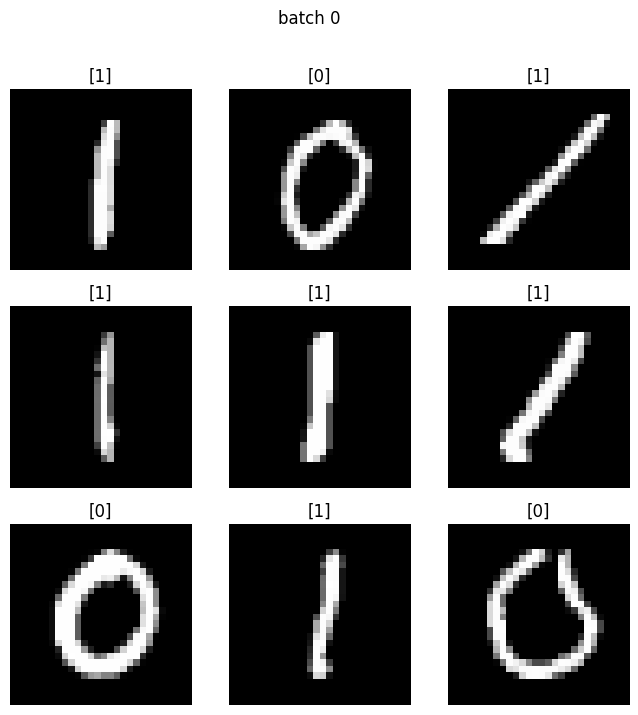

callback on batch 1
Xtr shape (200, 1, 28, 28, 1), Ytr shape (200, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


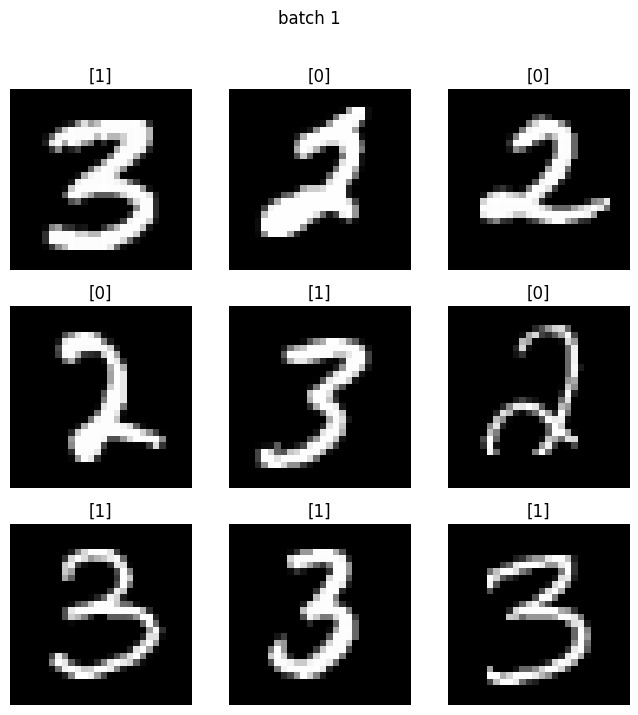

callback on batch 2
Xtr shape (200, 1, 28, 28, 1), Ytr shape (200, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


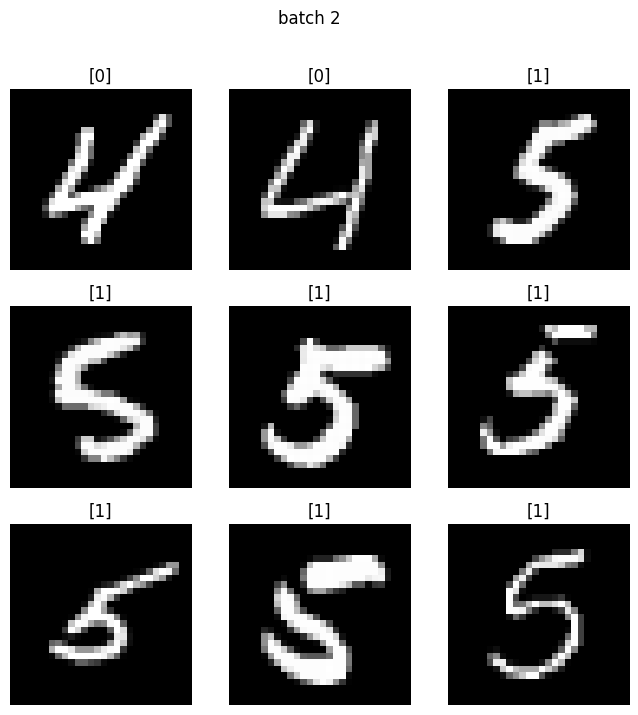

callback on batch 3
Xtr shape (200, 1, 28, 28, 1), Ytr shape (200, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


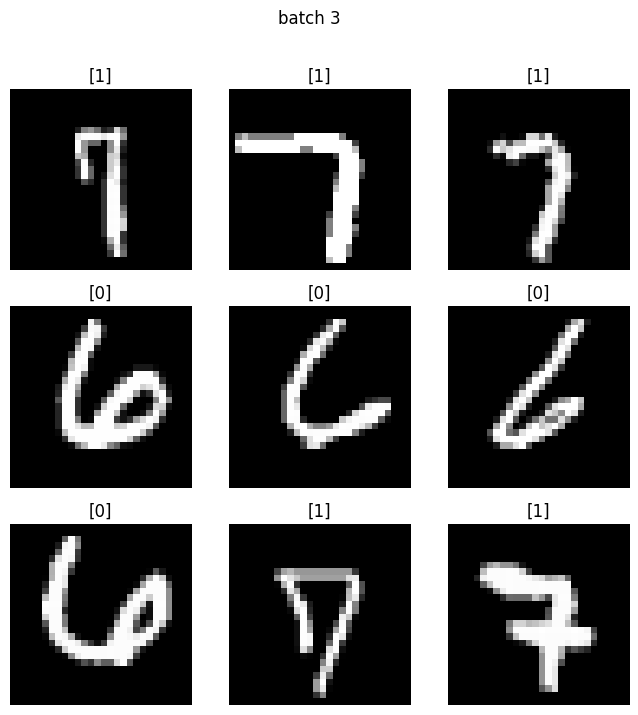

callback on batch 4
Xtr shape (200, 1, 28, 28, 1), Ytr shape (200, 1)
Xte shape (500, 1, 28, 28, 1), Yte shape (500, 1)


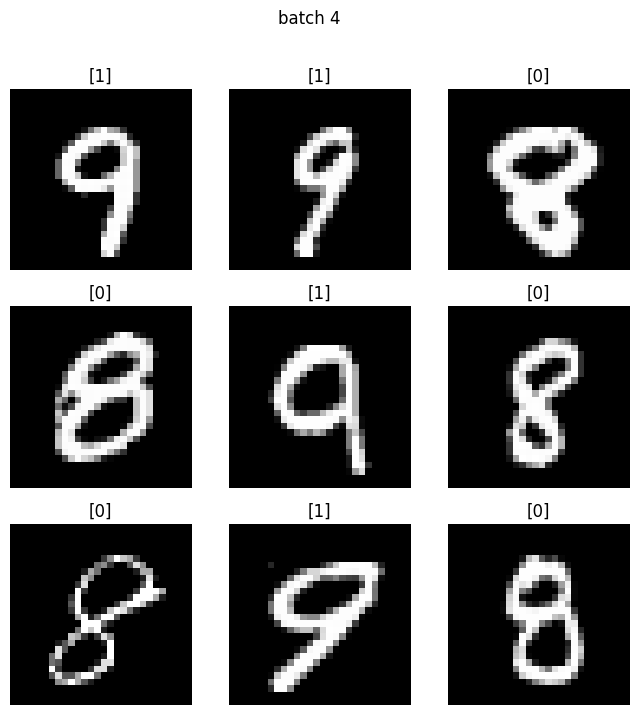

In [8]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

def callback_dl(b, bel_pre, bel_post, batch, **kwargs):
    Xtr, Ytr = batch
    jax.debug.print("callback on batch {b}", b=b)
    jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
    Xte, Yte = next(test_iter)
    jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
    plot_batch(Xte, Yte, ttl='batch {:d}'.format(b))
    return b

shape_in = Xtr.shape[1:]
shape_out = 1
estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)

bel, outputs = estimator.scan_dataloader(train_loader, callback=callback_dl)
Xsum = jnp.sum(Xtr, axis=0)
# assert(jnp.allclose(Xsum, bel.dummy, atol=1e-1))

# 2. Model Setup

In [14]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

features = [400, 400, 1]
model = MLP(features)
params = model.init(jr.PRNGKey(0), jnp.ones([1, 28, 28, 1]).ravel())
flat_params, unflatten_fn = ravel_pytree(params)

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)
print(f'flat_params.shape: {flat_params.shape}')

flat_params.shape: (474801,)


In [15]:
# class CNN(nn.Module):
#     """A simple CNN model."""
#     @nn.compact
#     def __call__(self, x):
#         x = nn.Conv(features=32, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = nn.Conv(features=64, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = x.reshape((x.shape[0], -1))  # flatten
#         x = nn.Dense(features=128)(x)
#         x = nn.relu(x)
#         x = nn.Dense(features=1)(x)
#         return x

# key = jr.PRNGKey(0)
# cnn_model = CNN()
# cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
# flat_params, unflatten_fn = ravel_pytree(cnn_params)
# print(f'flat_params.shape: {flat_params.shape}')

# # Define apply function
# def apply(flat_params, x, model, unflatten_fn):
#     return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

# apply_fn = partial(apply, model=cnn_model, unflatten_fn=unflatten_fn)

In [16]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# 3. FDEKF

## 3.1 Hyperparam Tuning

To tune the hyperparameters, we maximize the average validation accuracy across all 5 tasks after training on the full training set.

In [12]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}
fcekf_model = 'fdekf'

In [9]:
def evaluate_accuracy(flat_params, apply_fn, X, y):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_acc(image, label):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image).ravel()
        acc = jnp.mean(jnp.round(jax.nn.sigmoid(logits)) == label.ravel())
        
        return acc
    accs = vmap(evaluate_acc, (0, 0))(X, y).mean()
    return accs

def acc_callback(bel, *args, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test, y_test)
    
    result = {
        'test': accuracy,
    }
    
    return result

def ll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).ravel()
    nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test.ravel()))
    if jnp.isnan(nll):
        nll = 1e8
    result = -nll
    
    res = {
        "test": result,
    }
    return res

In [16]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'fdekf',
)

In [17]:
%%time
fdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -210.3    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -224.1    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -166.8    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.692    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.281    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.7912   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6921   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -1.075    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.5135   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4738   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -9.449e+0 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -1.315e+0 | -11.25    | 

## 3.2 Test Set Accuracy

In [12]:
fdekf_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [13]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer)
fdekf_estimator = hpt.build_estimator(flat_params, fdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="fdekf")

In [14]:
fdekf_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [15]:
def test_acc_callback(i, bel_pre, bel_post, batch, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    X_test, y_test = X_test[:(i+1)*ntest_per_batch], y_test[:(i+1)*ntest_per_batch]
    apply_fn = kwargs["apply_fn"]
    
    overall_accuracy = evaluate_accuracy(bel_post.mean, apply_fn, X_test, y_test)
    task1_accuracy = evaluate_accuracy(bel_post.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [16]:
def evaluate_model(estimator, n_iter=10):
    overall_accs, task1_accs = [], []
    for i in trange(n_iter):
        (Xtr, Ytr), _, (Xte, Yte) = load_split_mnist_dataset(key=i)
        train_ds = jdl.Dataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)
        test_ds = jdl.Dataset(Xte, Yte)
        test_loader = jdl.DataLoaderJax(test_ds, batch_size=nval_per_batch, shuffle=False, drop_last=False)

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': ntest_per_batch,
            'apply_fn': apply_fn,
        }

        _, accs = estimator.scan_dataloader(train_loader, callback=test_acc_callback, **test_kwargs)

        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, task1_accs = jnp.array(overall_accs), jnp.array(task1_accs)

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result


In [19]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 10/10 [03:13<00:00, 19.32s/it]


In [20]:
fdekf_res

{'overall': Array([0.9940001, 0.9204001, 0.8761334, 0.8748   , 0.8061199], dtype=float32),
 'overall-std': Array([0.00296648, 0.01446513, 0.01589074, 0.01330639, 0.00814871],      dtype=float32),
 'task1': Array([0.9940001 , 0.98340005, 0.903     , 0.87620014, 0.81400007],      dtype=float32),
 'task1-std': Array([0.00296648, 0.00872009, 0.02626405, 0.01753739, 0.02762608],      dtype=float32)}

# 4. VDEKF

## 4.1 Hyperparam Tuning

In [24]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'vdekf',
)

In [25]:
%%time
vdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -51.89    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -3.727e+0 | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -504.2    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.692    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.226    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.7865   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6922   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -0.5697   | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.5132   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4736   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -5.002e+0 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -5.426e+0 | -11.25    | 

## 4.2 Test Set Accuracy

In [21]:
vdekf_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [22]:
# vdekf_hparams = hpt.get_best_params(vdekf_optimizer)
vdekf_estimator = hpt.build_estimator(flat_params, vdekf_hparams, emission_mean_function,
                                      emission_cov_function, method="vdekf")

In [23]:
vdekf_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [24]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 10/10 [03:15<00:00, 19.54s/it]


In [25]:
vdekf_res

{'overall': Array([0.9940001, 0.9204001, 0.8761334, 0.8748   , 0.80624  ], dtype=float32),
 'overall-std': Array([0.00296648, 0.01446513, 0.01589074, 0.01330639, 0.00817644],      dtype=float32),
 'task1': Array([0.9940001 , 0.98340005, 0.903     , 0.8764001 , 0.81400007],      dtype=float32),
 'task1-std': Array([0.00296648, 0.00872009, 0.02626405, 0.01763633, 0.02762608],      dtype=float32)}

# 5. LoFi-Orth

## 5.1 Hyperparam Tuning

In [28]:
lofi_params_spherical = LoFiParams(
    memory_size=50,
    diagonal_covariance=False,
)

In [32]:
lofi_orth_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi_orth', params_lofi=lofi_params_spherical
)

In [33]:
%%time
lofi_orth_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8081   | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -0.902    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -0.7306   | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.6921   | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -0.938    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.716    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.6924   | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -1.152    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.4941   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.468    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -5.487e+0 | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -51.63    | -11.25    | 

## 5.2 Test Set Accuracy

In [29]:
lofi_orth_hparams = {
    'initial_covariance': 0.0010313810518482653,
    'dynamics_weights': 0.9999999999999791,
    'dynamics_covariance': 2.1137513659049582e-14,
    'dynamics_covariance_inflation_factor': 6.010309295351233e-10
}

In [30]:
# lofi_orth_hparams = hpt.get_best_params(lofi_orth_optimizer)
lofi_orth_estimator = hpt.build_estimator(flat_params, lofi_orth_hparams, emission_mean_function,
                                          emission_cov_function, method="lofi_orth", 
                                          lofi_params=lofi_params_spherical)

In [31]:
lofi_orth_hparams

{'initial_covariance': 0.0010313810518482653,
 'dynamics_weights': 0.9999999999999791,
 'dynamics_covariance': 2.1137513659049582e-14,
 'dynamics_covariance_inflation_factor': 6.010309295351233e-10}

In [32]:
lofi_orth_res = evaluate_model(lofi_orth_estimator)

100%|██████████| 10/10 [04:05<00:00, 24.52s/it]


In [33]:
lofi_orth_res

{'overall': Array([0.9940001 , 0.91940016, 0.8766667 , 0.8747501 , 0.80748   ],      dtype=float32),
 'overall-std': Array([0.00296648, 0.01443745, 0.01498443, 0.01378088, 0.00815853],      dtype=float32),
 'task1': Array([0.9940001 , 0.98340005, 0.90620005, 0.8790001 , 0.8166    ],      dtype=float32),
 'task1-std': Array([0.00296648, 0.00872009, 0.02596074, 0.01644993, 0.02607759],      dtype=float32)}

# 6. LoFi-Spherical

## 6.1 Hyperparam Tuning

In [18]:
lofi_sph_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi', params_lofi=lofi_params_spherical
)

In [19]:
%%time
lofi_sph_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9947   | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -1.227    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -0.7304   | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -0.6923   | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -0.4849   | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -0.4298   | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -0.693    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -13.62    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -0.3664   | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -0.4306   | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -25.96    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -215.3    | -11.25    | 

## 6.2 Test Set Accuracy

In [34]:
lofi_sph_hparams = {
    'initial_covariance': 0.0018779857408277372,
    'dynamics_weights': 0.999999999999999,
    'dynamics_covariance': 8.425795301903653e-09,
    'dynamics_covariance_inflation_factor': 3.634315308333528e-14
}

In [35]:
# lofi_sph_hparams = hpt.get_best_params(lofi_sph_optimizer)
lofi_sph_estimator = hpt.build_estimator(flat_params, lofi_sph_hparams, emission_mean_function,
                                         emission_cov_function, method="lofi", 
                                         lofi_params=lofi_params_spherical)

In [36]:
lofi_sph_hparams

{'initial_covariance': 0.0018779857408277372,
 'dynamics_weights': 0.999999999999999,
 'dynamics_covariance': 8.425795301903653e-09,
 'dynamics_covariance_inflation_factor': 3.634315308333528e-14}

In [37]:
lofi_sph_res = evaluate_model(lofi_sph_estimator)

100%|██████████| 10/10 [13:47<00:00, 82.74s/it]


In [38]:
lofi_sph_res

{'overall': Array([0.99500006, 0.9357001 , 0.9122667 , 0.9163    , 0.87492007],      dtype=float32),
 'overall-std': Array([0.00240832, 0.0076948 , 0.0058515 , 0.00660758, 0.00808168],      dtype=float32),
 'task1': Array([0.99500006, 0.98800004, 0.9566    , 0.941     , 0.9132    ],      dtype=float32),
 'task1-std': Array([0.00240832, 0.004     , 0.01196829, 0.01290738, 0.01916664],      dtype=float32)}

# 7. LoFi-Diag

## 7.1 Hyperparam Tuning

In [39]:
lofi_params_diagonal = LoFiParams(
    memory_size=50,
    diagonal_covariance=True,
)

In [ ]:
lofi_diag_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model, pbounds, 314, train, val, emission_mean_function, emission_cov_function,
    ll_callback, 'lofi', params_lofi=lofi_params_diagonal
)

In [ ]:
%%time
lofi_diag_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | 0.5168    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | 0.51      | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | 0.4028    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | 0.51      | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | 0.6608    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | 0.6148    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | 0.51      | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | 0.6408    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | 0.7652    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | 0.8048    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | 0.51      | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | 0.51      | -11.25    | 

## 7.2 Test Set Accuracy

In [40]:
lofi_diag_hparams = {
    'initial_covariance': 0.0003191588918078341,
    'dynamics_weights': 0.9999999999999786,
    'dynamics_covariance': 6.308890416494091e-11,
    'dynamics_covariance_inflation_factor': 7.284599643419104e-14
}

In [41]:
# lofi_diag_hparams = hpt.get_best_params(lofi_diag_optimizer)
lofi_diag_estimator = hpt.build_estimator(flat_params, lofi_diag_hparams, emission_mean_function,
                                          emission_cov_function, method="lofi", 
                                          lofi_params=lofi_params_diagonal)

In [42]:
lofi_diag_hparams

{'initial_covariance': 0.0003191588918078341,
 'dynamics_weights': 0.9999999999999786,
 'dynamics_covariance': 6.308890416494091e-11,
 'dynamics_covariance_inflation_factor': 7.284599643419104e-14}

In [43]:
lofi_diag_res = evaluate_model(lofi_diag_estimator)

100%|██████████| 10/10 [24:02<00:00, 144.25s/it]


In [44]:
lofi_diag_res

{'overall': Array([0.9628    , 0.85830003, 0.82993335, 0.84700006, 0.80104   ],      dtype=float32),
 'overall-std': Array([0.01403423, 0.01681695, 0.01298358, 0.01403033, 0.00969322],      dtype=float32),
 'task1': Array([0.9628    , 0.95600003, 0.9296002 , 0.9332    , 0.93740004],      dtype=float32),
 'task1-std': Array([0.01403423, 0.01080741, 0.01651182, 0.01440001, 0.00984073],      dtype=float32)}

# 8. Online SGD

## 8.1 Hyperparam Tuning

In [11]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = vmap(state.apply_fn, (None, 0))(params, batch_images).ravel()
        loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, batch_labels.ravel()))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [12]:
def train_model(state, X_train, y_train):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
    
        return state, state
    
    state, _ = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state

In [13]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.exp(log_lr))
    opt_state = TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    opt_state = train_model(opt_state, Xtr, Ytr)

    result = evaluate_accuracy(opt_state.params, apply_fn, Xte, Yte)
    if jnp.isnan(result):
        result = 0.0

    return result

In [ ]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-15.0, 0.0)}
)

In [ ]:
sgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | 0.8076    | -8.423    |
| 2         | 0.4668    | -14.33    |
| 3         | 0.8092    | -8.482    |
| 4         | 0.6032    | -4.041    |
| 5         | 0.5524    | -3.24     |
| 6         | 0.6872    | -6.448    |
| 7         | 0.8212    | -8.739    |
| 8         | 0.5608    | -11.32    |
| 9         | 0.778     | -7.999    |
| 10        | 0.76      | -10.28    |
| 11        | 0.6452    | -5.347    |
| 12        | 0.7992    | -9.811    |
| 13        | 0.7416    | -7.537    |
| 14        | 0.69      | -6.614    |
| 15        | 0.6364    | -5.133    |
| 16        | 0.6048    | -11.1     |
| 17        | 0.5972    | -3.839    |
| 18        | 0.6104    | -4.165    |
| 19        | 0.6988    | -6.878    |
| 20        | 0.668     | -5.88     |
| 21        | 0.0       | 0.0       |
| 22        | 0.8204    | -9.211    |
| 23        | 0.824     | -8.971    |
| 24        | 0.8228    | -8.885    |
| 25        

In [ ]:
# 'log_lr': -8.978492212327534
print(sgd_optimizer.max)

{'target': 0.824400007724762, 'params': {'log_lr': -8.978492212327534}}


## 8.2 Test Set Accuracy

In [17]:
log_lr = -8.978492212327534

tx = optax.sgd(jnp.exp(log_lr))
opt_state = TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

In [18]:
def evaluate_model_sgd(state, ntrain_per_batch=ntrain_per_batch, ntest_per_batch=ntest_per_batch, n_iter=10):
    overall_accs, task1_accs = [], []
    
    for i in trange(n_iter):
        (Xtr, Ytr), _, (Xte, Yte) = load_split_mnist_dataset(key=i)
        first_Xte, first_Yte = Xte[:ntest_per_batch], Yte[:ntest_per_batch]
        trained_state = state
        oa_accs, t1_accs = [], []
        for i in range(Xtr.shape[0] // ntrain_per_batch):
            curr_Xtr = Xtr[i*ntrain_per_batch:(i+1)*ntrain_per_batch]
            curr_Ytr = Ytr[i*ntrain_per_batch:(i+1)*ntrain_per_batch]
            curr_Xte = Xte[:(i+1)*ntest_per_batch]
            curr_Yte = Yte[:(i+1)*ntest_per_batch]
            
            trained_state = train_model(trained_state, curr_Xtr, curr_Ytr)
            accs = evaluate_accuracy(trained_state.params, apply_fn, curr_Xte, curr_Yte)
            oa_accs.append(accs)

            accs = evaluate_accuracy(trained_state.params, apply_fn, first_Xte, first_Yte)
            t1_accs.append(accs)
        
        overall_accs.append(oa_accs)
        task1_accs.append(task1_accs)
        del trained_state, oa_accs, t1_accs, Xtr, Ytr, Xte, Yte, first_Xte, first_Yte, curr_Xtr, curr_Ytr, curr_Xte, curr_Yte
    
    overall_accs, task1_accs = jnp.array(overall_accs), jnp.array(task1_accs)
    
    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0) 
    }

    return result

In [19]:
online_sgd_res = evaluate_model_sgd(opt_state, n_iter=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
online_sgd_res

# 9. Offline SGD (baseline)

In [ ]:
num_epochs, batch_size, key = 20_000, 32, jr.PRNGKey(0)

sgd_state = TrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=optax.sgd(learning_rate=1e-2)
)

In [ ]:
@partial(jit, static_argnums=(3,))
def sgd_loss_fn(params, X_batch, y_batch, apply_fn):
    logits = vmap(apply_fn, (None, 0))(params, X_batch).ravel()
    nll = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y_batch.ravel()))

    return nll

In [ ]:
sgd_state, losses = sgd.train_full(
    key, num_epochs, batch_size, sgd_state, Xtr, Ytr, sgd_loss_fn, Xte, Yte
)

In [ ]:
offline_sgd_overall_acc = evaluate_accuracy(sgd_state.params, apply_fn, Xte, Yte)
offline_sgd_task1_accuracy = evaluate_accuracy(sgd_state.params, apply_fn, Xte[:ntest_per_batch], Yte[:ntest_per_batch])

In [ ]:
offline_sgd_overall_acc

In [ ]:
offline_sgd_task1_accuracy

# 9. Model Comparison

In [1]:
results = {
    'sgd': online_sgd_res,
    'fdekf': fdekf_res,
    'vdekf': vdekf_res,
    'lofi-orth': lofi_orth_res,
    'lofi_sph': lofi_sph_res,
    'lofi_diag': lofi_diag_res,
}

NameError: ignored

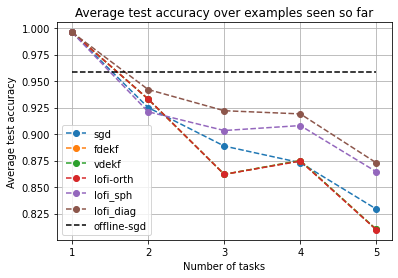

In [88]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(jnp.arange(1, 6), val['overall'], linestyle='--', marker='o', label=key);
    ax.errorbar(jnp.arange(1, 6), val['overall'], yerr=val['overall-std'], fmt='o')
ax.plot(jnp.arange(1, 6), [offline_sgd_overall_acc] * 5, 'k--', label='offline-sgd')
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Average test accuracy')
ax.set_xticks(jnp.arange(1, 6))
ax.grid()
ax.set_title('Average test accuracy over examples seen so far')
ax.legend();

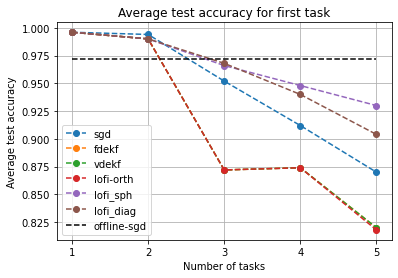

In [89]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(jnp.arange(1, 6), val['task1'], linestyle='--', marker='o', label=key);
    ax.errorbar(jnp.arange(1, 6), val['task1'], yerr=val['task1-std'], fmt='o')
ax.plot(jnp.arange(1, 6), [offline_sgd_task1_accuracy] * 5, 'k--', label='offline-sgd')
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Average test accuracy')
ax.set_xticks(jnp.arange(1, 6))
ax.grid()
ax.set_title('Average test accuracy for first task')
ax.legend();